# Data exploration for **Data/processed**

---

This notebook intention is to explore, show and generate insights on the data that we already processed using the **dataset.py** and **features.py** in the image_generation directory. Give a general overview and perform an initial data exploration analysis to get to know our data better

### Libraries:

In [51]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image

During the **dataset.py** file we did web scrapping of the page: [Football Kit Archive](https://www.footballkitarchive.com), using the library `selenium` we could download **312** images from different teams. After the preprocessing of the images, where we added a black background and centered the jerseys:

In [52]:
RAW_DATA_DIR = "../data/raw/"
PROCCESSED_DATA_DIR = "../data/processed/"

total_images = 0
for image in os.listdir(PROCCESSED_DATA_DIR):
    total_images += 1

print(f"Total images: {total_images}")

Total images: 312


This is a comparation of an original image that we got from doing the webscrapping vs after the preprocessing:

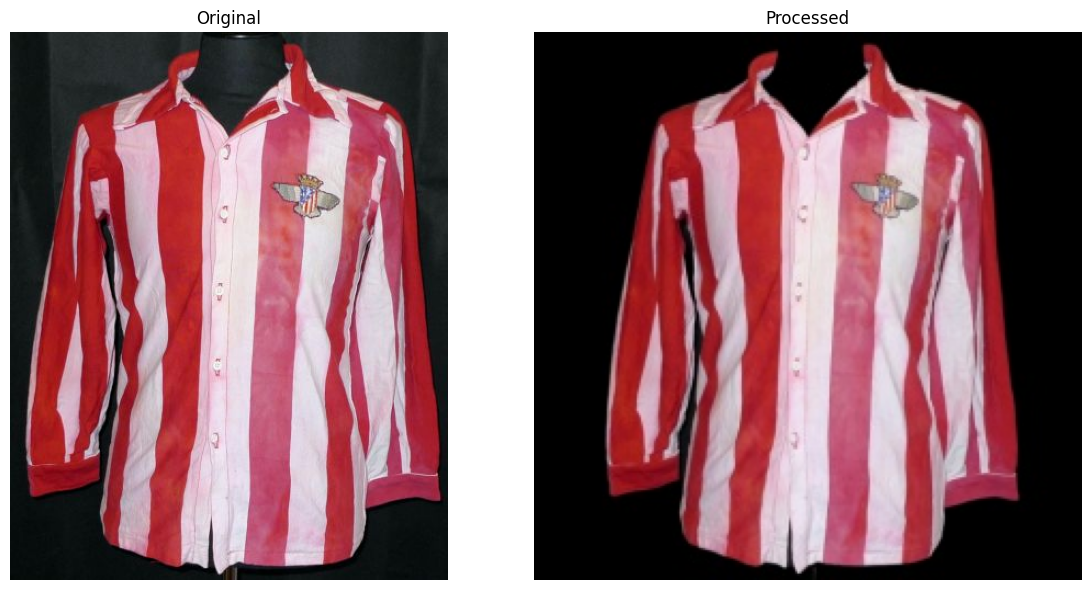

In [53]:
original_image = Image.open(os.path.join(RAW_DATA_DIR, os.listdir(RAW_DATA_DIR)[0]))
processed_image = Image.open(os.path.join(PROCCESSED_DATA_DIR, os.listdir(PROCCESSED_DATA_DIR)[0]))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(original_image)
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(processed_image)
axes[1].set_title("Processed")
axes[1].axis("off")

plt.tight_layout()
plt.show()

As we can see, the size of the original image is way too big for our **VAE** to process it, so we reduced it in the `features.py` file, let's see the new shape of the image and if it is consistent in the images:

In [54]:
sample_images_names = [image_name for image_name in os.listdir(PROCCESSED_DATA_DIR)][:5] #Make 5 samples (first 5 images)
sample_images = [Image.open(os.path.join(PROCCESSED_DATA_DIR, name)).convert("RGB") for name in sample_images_names]

In [55]:
for image in sample_images:
    img_array = np.array(image)
    print(f"Image shape: {img_array.shape}")

Image shape: (256, 256, 3)
Image shape: (256, 256, 3)
Image shape: (256, 256, 3)
Image shape: (256, 256, 3)
Image shape: (256, 256, 3)


Our shape is the same for all images in our processed data, so it won't need to be necessary to do some resizing before giving it to the `AutoEncoder`

Most of the images that we downloaded are from teams that have <font color="red">red</font> and <font color="white">white</font> strips as the Home kit jersey, so let's see if our dataset is skewed towards certain colors. For this, we are going to use a few random samples an then make an analysis by r, g, b of the images and create an average color by image.

In [56]:
img_arrays = [np.array(image) for image in sample_images]
channel_data = [img_array[:, :, 0] for img_array in img_arrays]

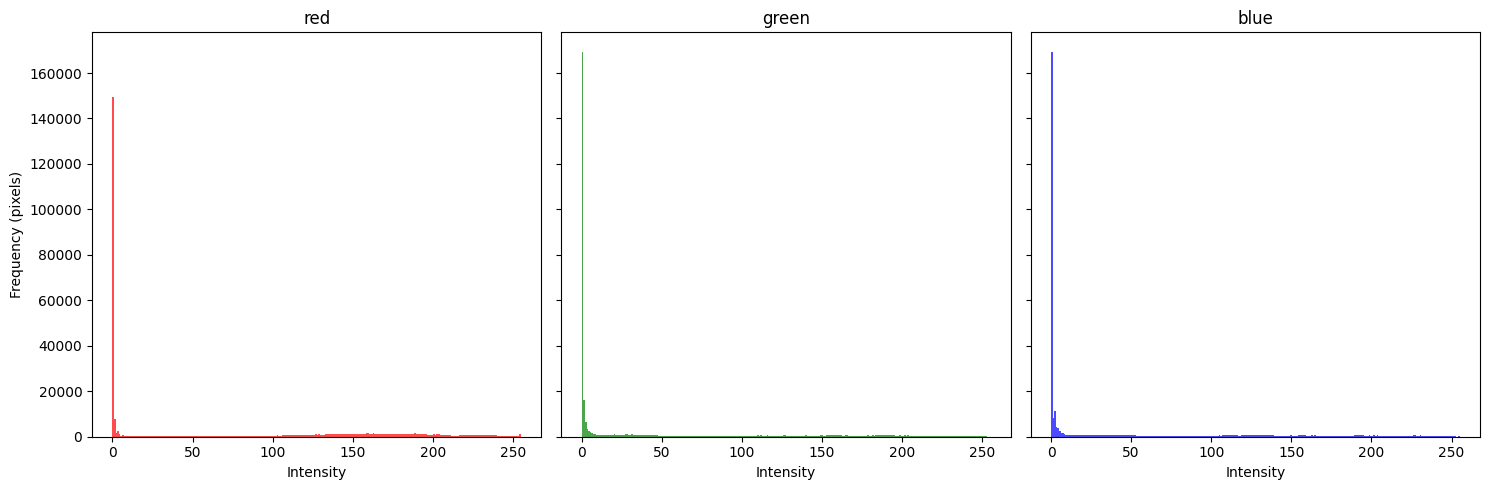

In [57]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

colors = ('red', 'green', 'blue')

for i in range(3):
    data = np.concatenate([img[:, :, i].flatten() for img in img_arrays])

    axs[i].hist(data, bins=256, color=colors[i], alpha=0.7)
    axs[i].set_title(colors[i])
    axs[i].set_xlabel('Intensity')
    if i == 0:
        axs[i].set_ylabel('Frequency (pixels)')

plt.tight_layout()
plt.show()

As we can see in the distributions, the `0` values indicate that most of the image is black (so the background apparently works well), our focus would be to try to learn from the rest of the distribution.

Let's see how the mean of the jerseys look.

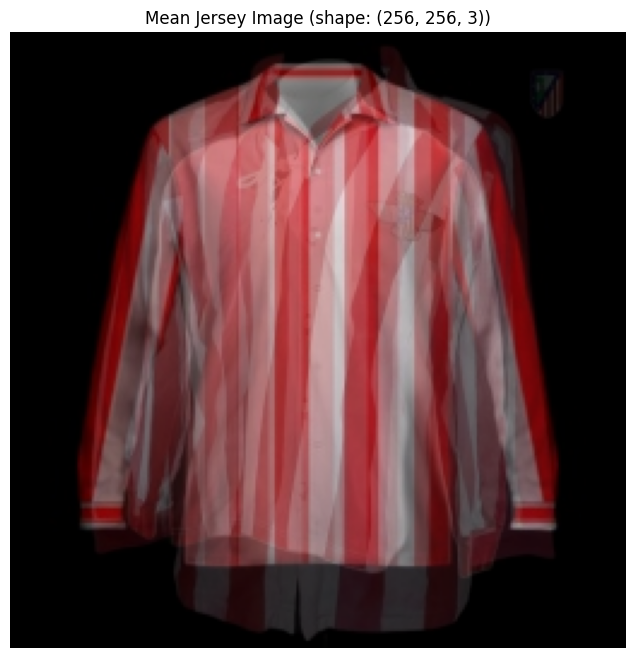

In [58]:
images_stack = np.stack(img_arrays, axis=0)
mean_image_float = np.mean(images_stack, axis=0)

mean_image_uint8 = mean_image_float.astype(np.uint8)
plt.figure(figsize=(8, 8))
plt.imshow(mean_image_uint8)
plt.title(f"Mean Jersey Image (shape: {mean_image_uint8.shape})")
plt.axis('off') 
plt.show()

The final conclusions of this notebook are:

1. **Pre-processing Impact**: The transition from raw to processed images ensures that all inputs are standardized. Converting to a uniform size and RGB color space eliminates noise and prepares the data for consistent feature extraction, the background and centering are a key factor in this process.

2. **Color Distribution**: Through the channel-wise histograms, we identified the dominant color profiles across our samples, which will be critical for understanding class imbalances or lighting variations.

3. **The "Mean Jersey"**: Generating the average image of our samples revealed a consistent spatial structure (the "ghost" silhouette of a jersey). This confirms that our alignment and centering are consistent, providing a stable "template" for the neural network to learn from.

Next Steps: With the data cleaned and the underlying patterns visualized, we are now ready to proceed with data augmentation and the construction of our Variational AutoEncoder